In [7]:
# for basic operations
import numpy as np
!pip install nbconvert
!pip install nbconvert

# Widen the display of python output
# This is done to avoid ellipsis appearing which restricts output view in row or column
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# for modeling
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold, StratifiedKFold, RepeatedKFold, train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, accuracy_score

# to avoid warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from collections import Counter

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML


In [8]:
# reading the data
data = pd.read_csv(r"D:\Data Sets\uci-secom.csv")

# getting the shape of the data
# Dataset has 1,567 rows and 592 columns
print(data.shape)

(1567, 592)


In [9]:
#Add a prefix to the column names for easeof understanding
data.columns = 'feature_' + data.columns

In [10]:
#Rename the time column and Pass_Fail column as they are not features 
data.rename(columns = {'feature_Time':'Time'}, inplace = True) 
data.rename(columns = {'feature_Pass/Fail':'Pass_Fail'}, inplace = True)

In [11]:
# checking if the dataset contains any NULL values
# we do have NaN values if we see the output above

data.isnull().any().any()

True

In [12]:
# Replacing all the NaN values with 0 as the values correspond to the test results.
# since, the values are not present that means the values are not available or calculated
# Absence of a signal is assumed to be no signal in the dataset
# so better we not take median or mean and replace them with zeros

data = data.replace(np.NaN, 0)

# again, checking if there is any NULL values left
data.isnull().any().any()

False

In [13]:
unique_vals = data['Pass_Fail'].unique()  # [0, 1, 2]
targets = [data.loc[data['Pass_Fail'] == val] for val in unique_vals]

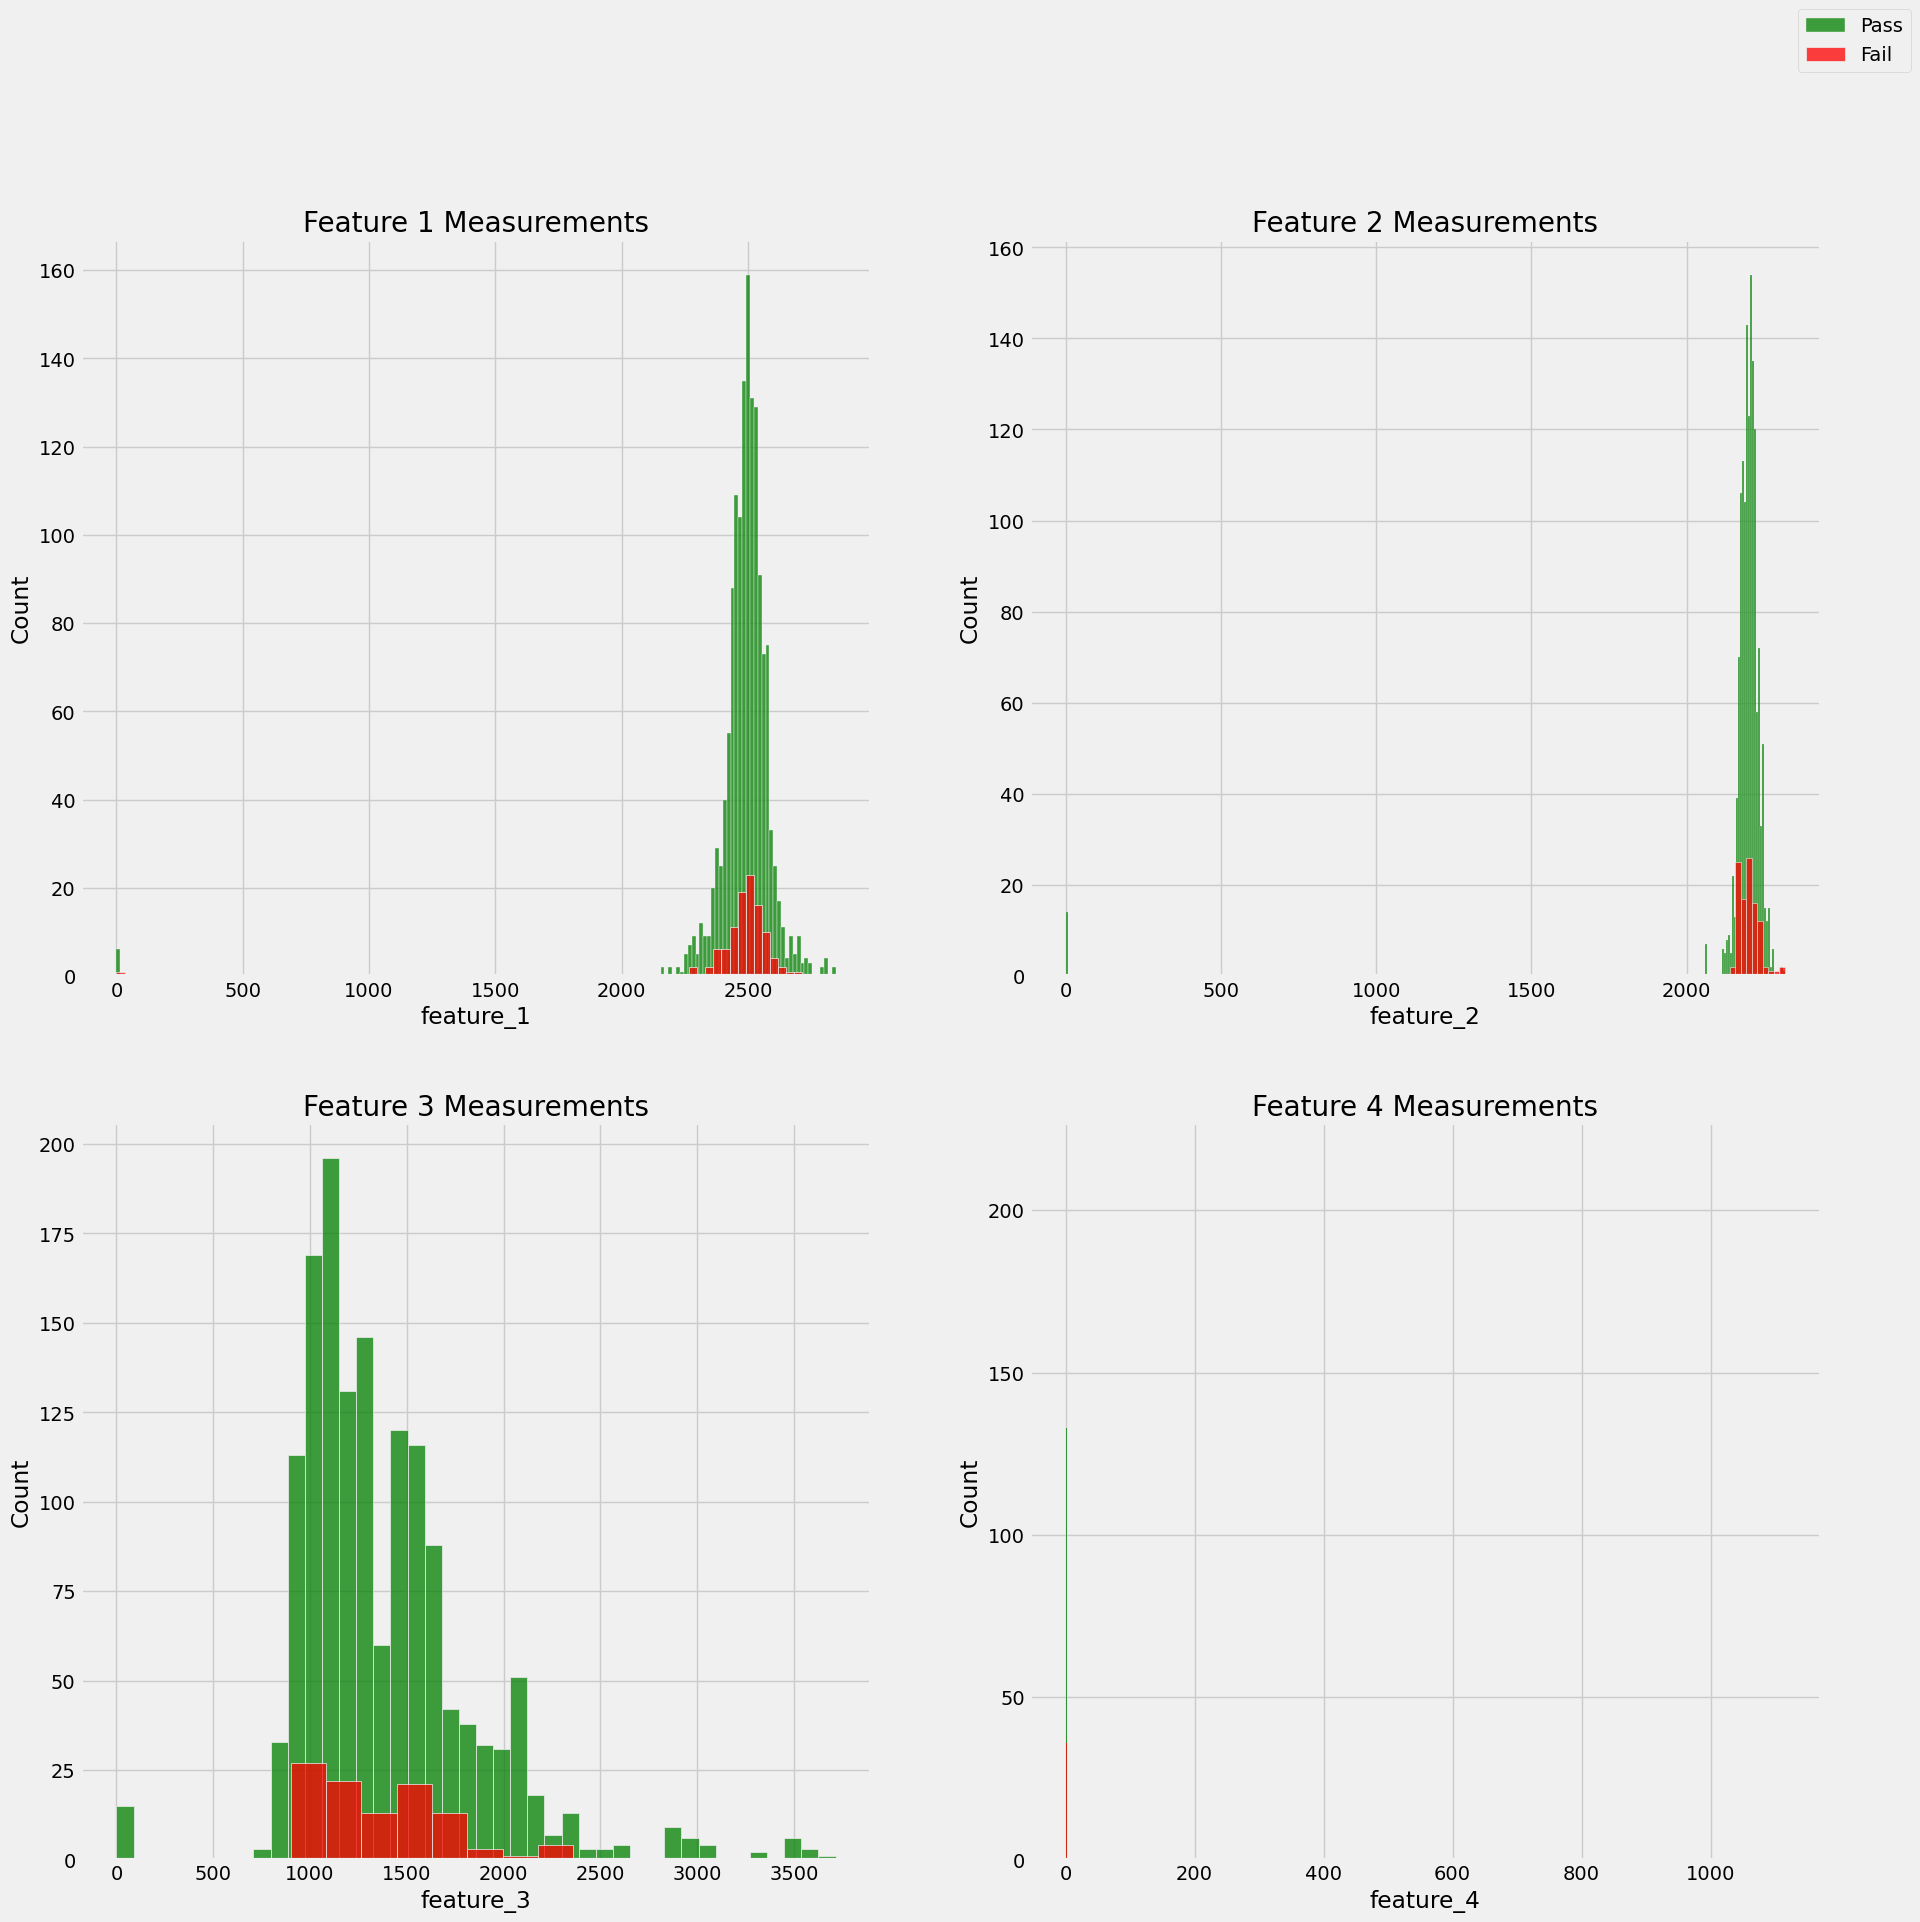

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))

colors = ['green', 'red', 'purple', 'green']  # Define colors for each histogram

for i, sensor in enumerate(['feature_1', 'feature_2', 'feature_3', 'feature_4']):
    plt.subplot(2, 2, i + 1)
    for target, color in zip(targets, colors):
        sns.histplot(target[sensor], color=color)
    plt.title(f'{sensor.replace("_", " ").title()} Measurements', fontsize=20)

fig.legend(labels=['Pass', 'Fail'], loc='upper right')
plt.show()


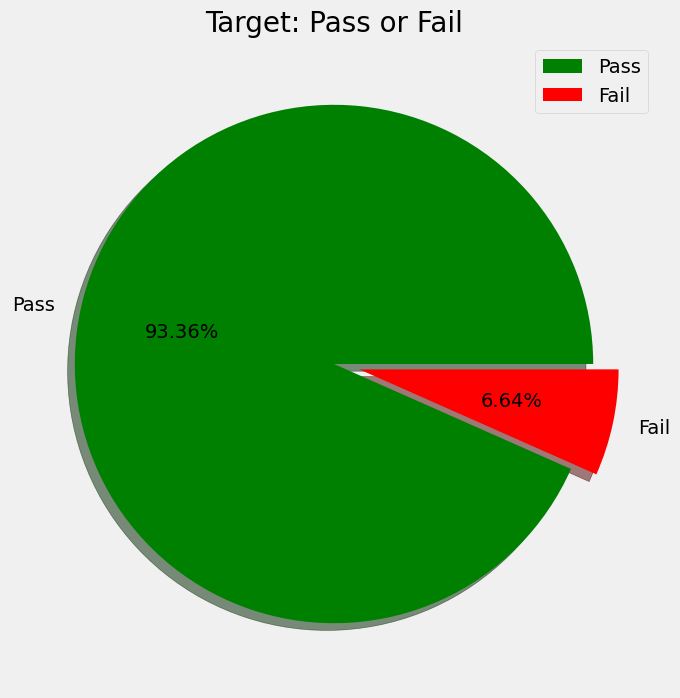

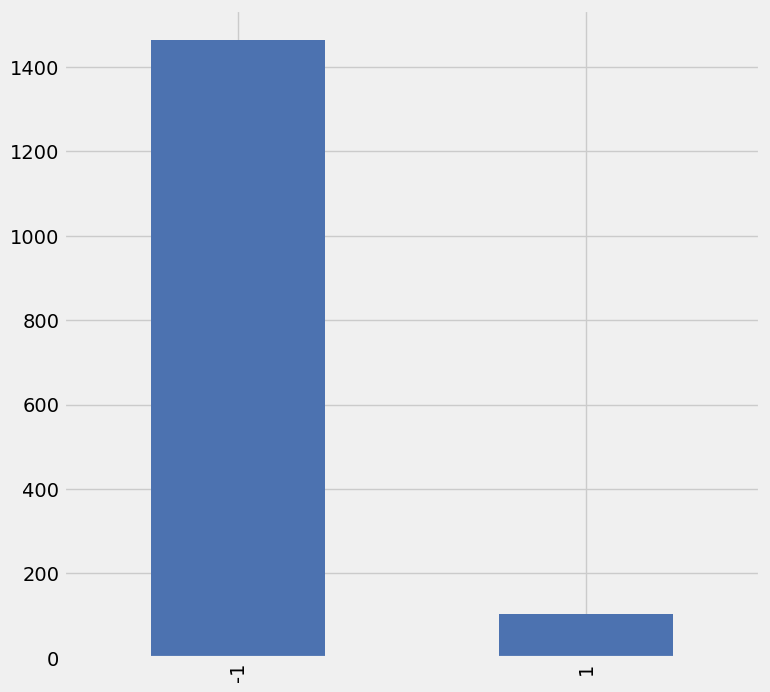

In [21]:
# pie chart
# We have highly imbalanced class with only 6.6% failures and 93.4% pass

labels = ['Pass', 'Fail']
size = data['Pass_Fail'].value_counts()
colors = ['green', 'red']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data['Pass_Fail'].value_counts().plot(kind="bar");

In [11]:
from datetime import datetime
data['year'] = pd.DatetimeIndex(data['Time']).year
data['month'] = pd.DatetimeIndex(data['Time']).month
data['date'] = pd.DatetimeIndex(data['Time']).day
data['week_day'] = pd.DatetimeIndex(data['Time']).weekday
data['start_time'] = pd.DatetimeIndex(data['Time']).time
data['hour'] = pd.DatetimeIndex(data['Time']).hour
data['min'] = pd.DatetimeIndex(data['Time']).minute

In [12]:
#This consists of only year 2008
print("Year: ", data.year.unique())
#This consists of all the months of 2008
print("Month: ", data.month.unique())
#All the dates of the month are not there, might be related to production on certain days only
print("Date: ", data.date.unique())
#All the weekdays of the month are here, so production happens on all 7 days
#0 stand for Sunday, 1 for Monday ... 6 for Saturday
print("Weekday: ", data.week_day.unique())

Year:  [2008]
Month:  [ 7  1  2  3  4  5  6  8  9 10 11 12]
Date:  [19 20 21 22 23 25 27 28 29 30 31  8 13 15 16 17 18 24  9 14 26 10]
Weekday:  [5 6 0 1 2 4 3]


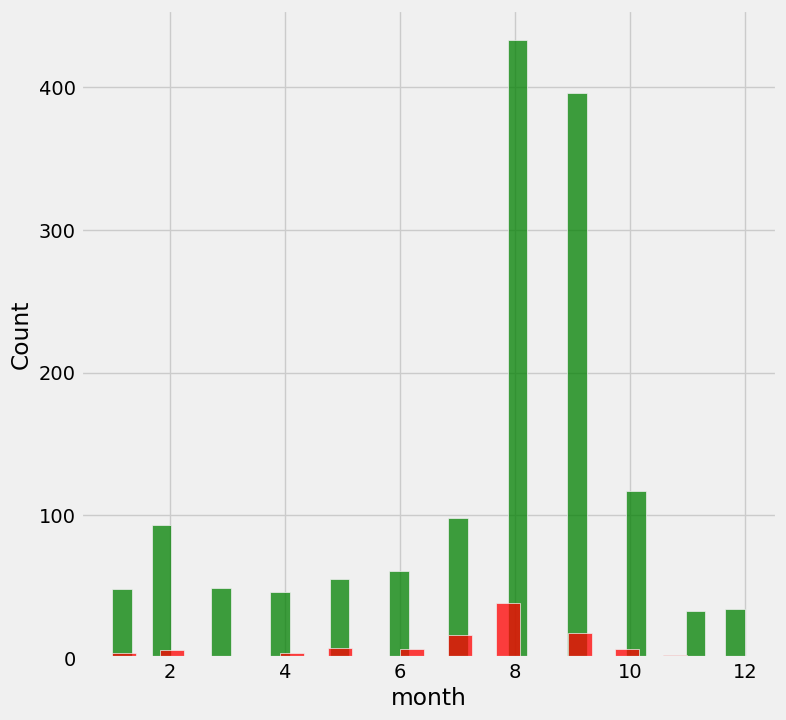

In [13]:
#We see that the failures (Pass_Fail=1) peak in August which is also the peak for pass.
#August and September are months with most product and most failures as well
#The failures seem to subside from September onwards post some correction 
#(May-Aug we see more failures than passes)
sns.histplot( data[data.Pass_Fail == -1]['month'], color = 'g');
sns.histplot( data[data.Pass_Fail == 1]['month'], color = 'r');

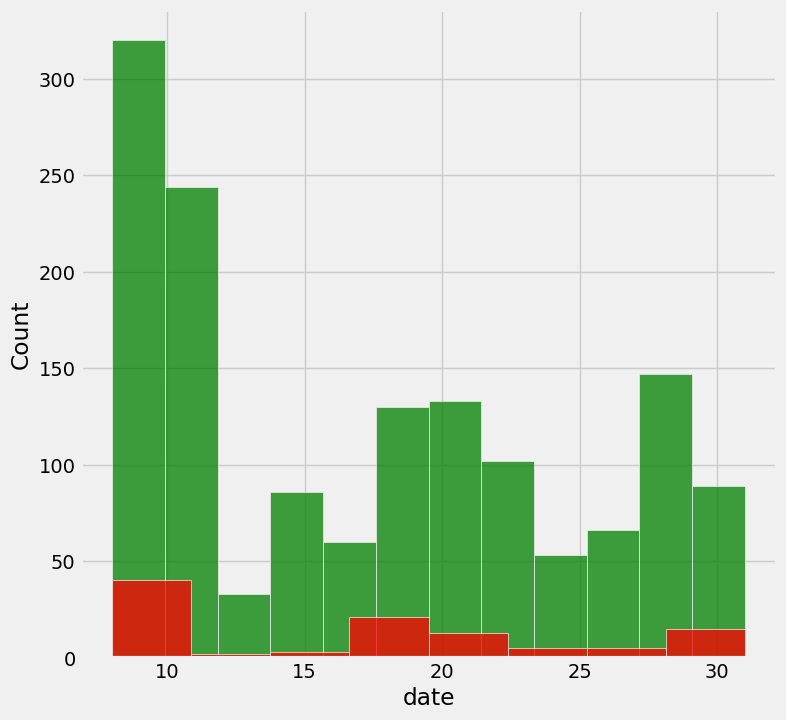

In [17]:
#The failures tend to decrease towards month end and is in close sync with pass population
sns.histplot( data[data.Pass_Fail == -1]['date'], color = 'g');
sns.histplot( data[data.Pass_Fail == 1]['date'], color = 'r');


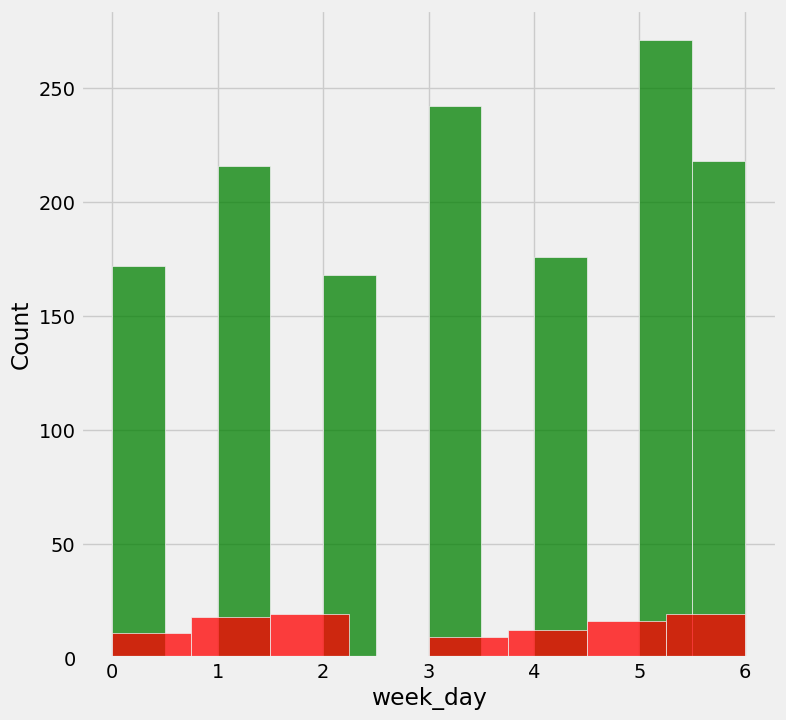

In [18]:
#Failures appear to be more towards start and end of the week rather than in the middle of the week
sns.histplot( data[data.Pass_Fail == -1]['week_day'], color = 'g');
sns.histplot( data[data.Pass_Fail == 1]['week_day'], color = 'r');


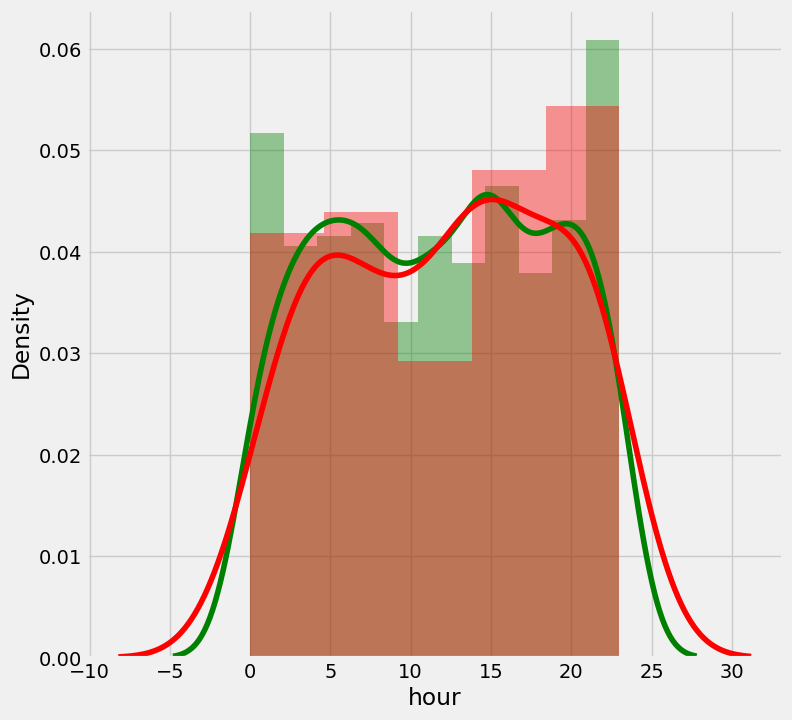

In [19]:
#There is no specific trend in terms of hours, it seems to be fairly distributed
sns.distplot( data[data.Pass_Fail == -1]['hour'], color = 'g');
sns.distplot( data[data.Pass_Fail == 1]['hour'], color = 'r');


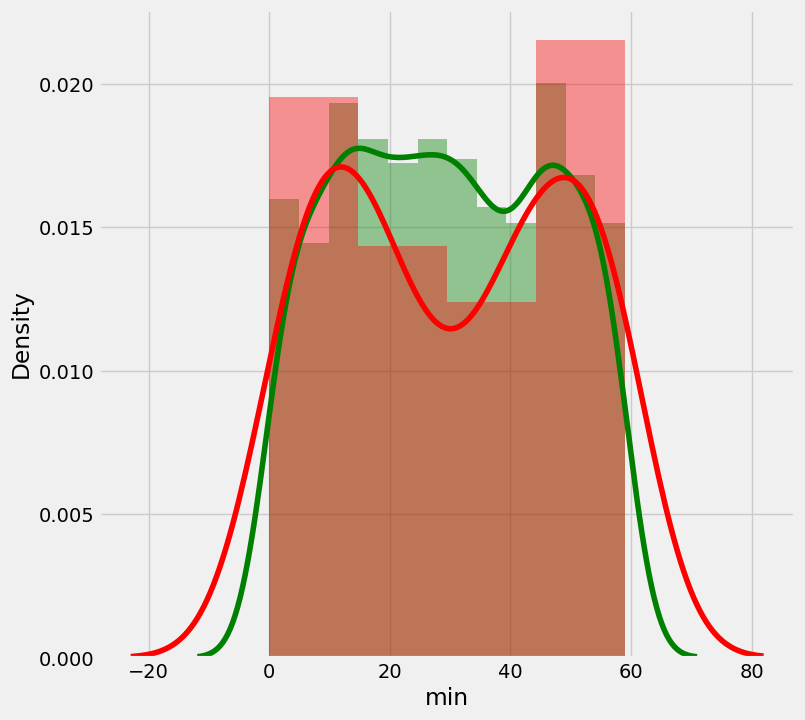

In [20]:
#There is no specific trend in terms of minutes, it seems to be fairly distributed
sns.distplot( data[data.Pass_Fail == -1]['min'], color = 'g');
sns.distplot( data[data.Pass_Fail == 1]['min'], color = 'r');

Text(0.5, 1.0, 'Correlation heatmap for the Data')

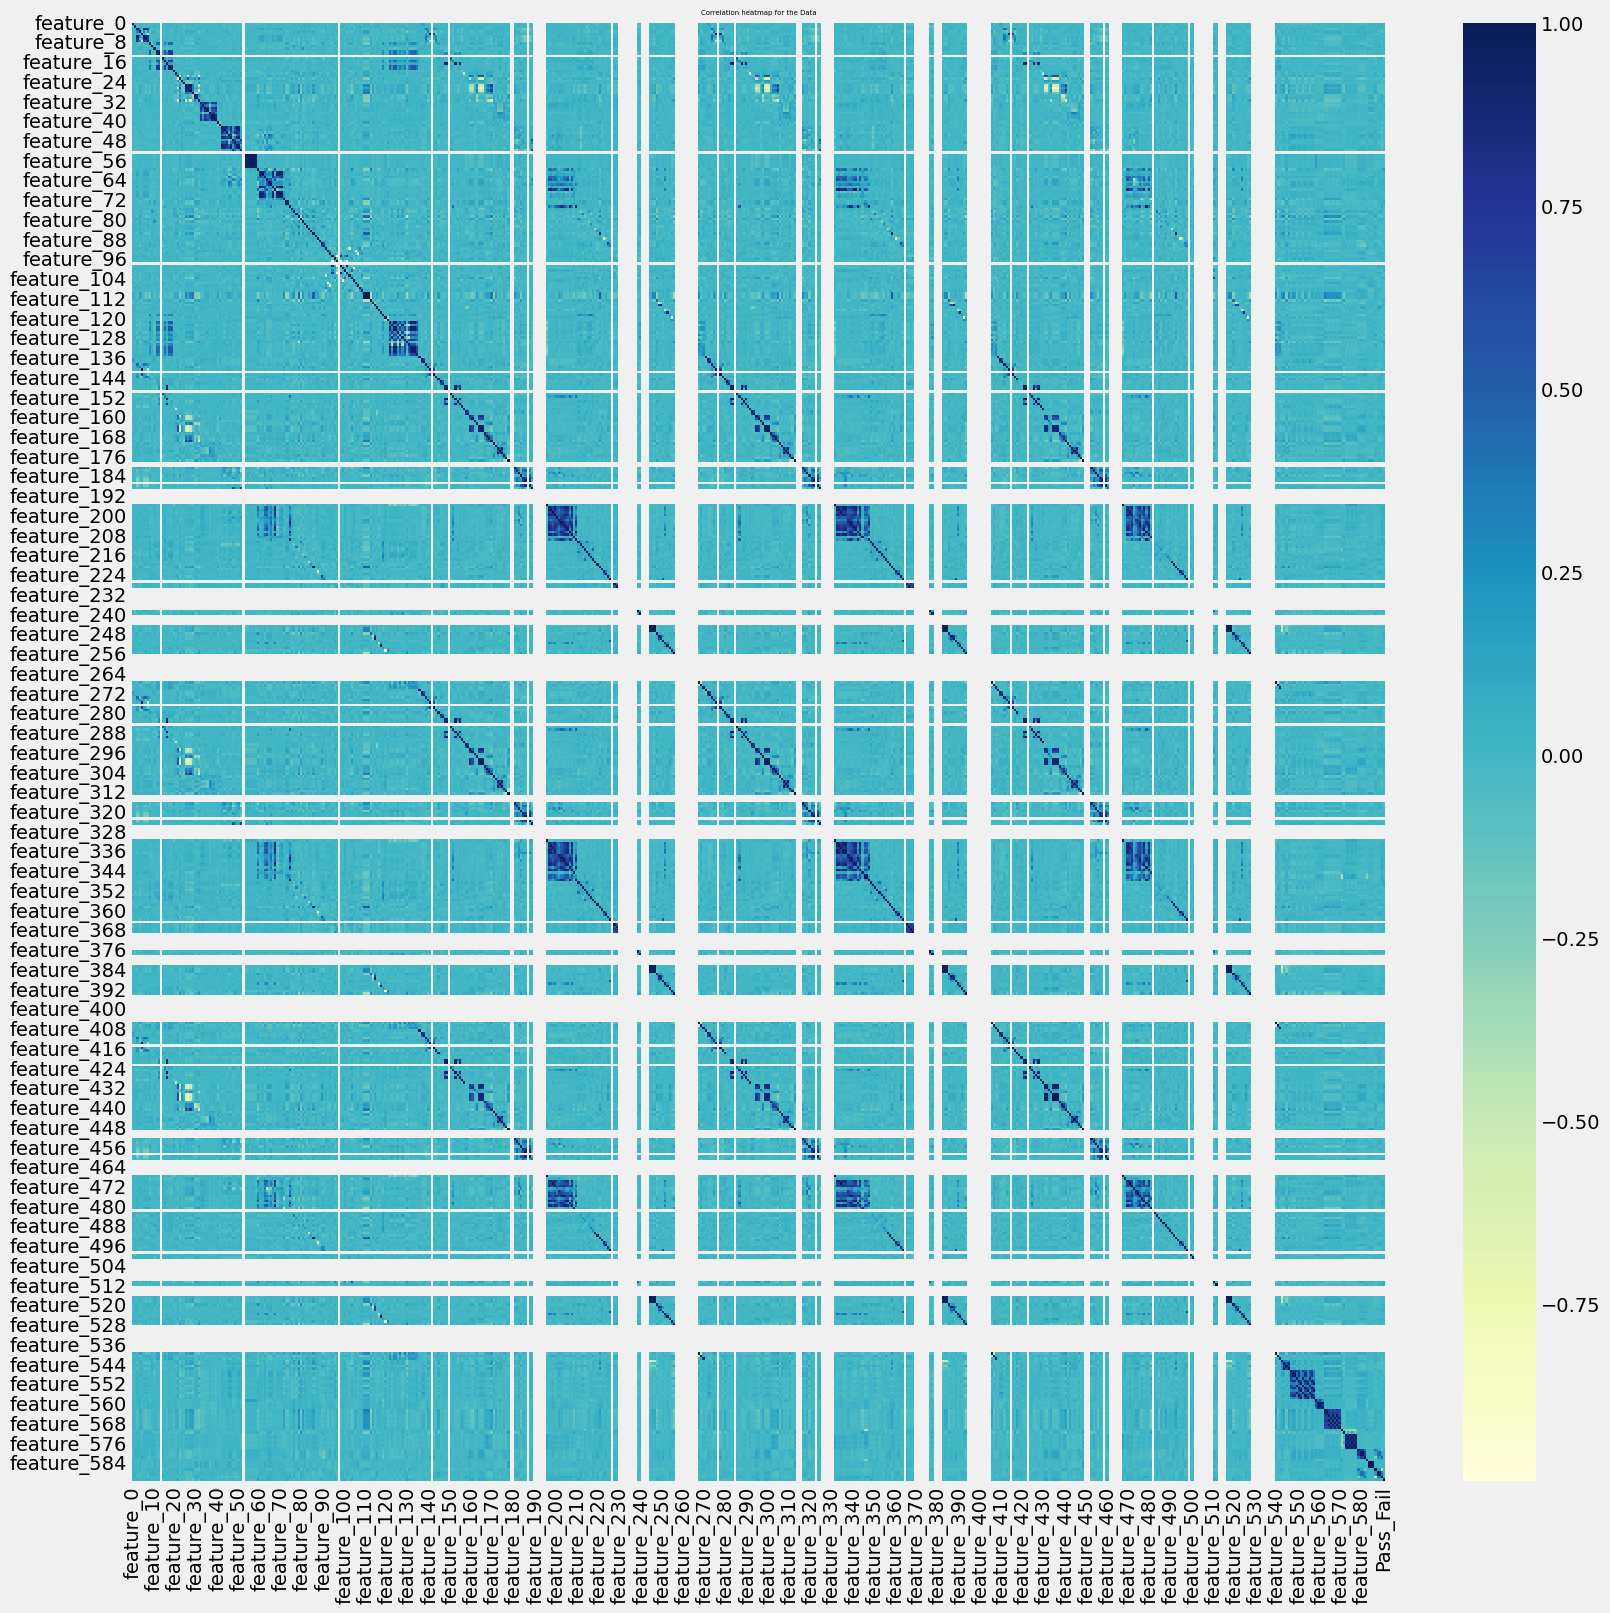

In [24]:
# heatmap to get correlation

plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(data.corr(), cmap = "YlGnBu")
plt.title('Correlation heatmap for the Data', fontsize = 5)

In [22]:
# deleting the time column 
data = data.drop(columns = ['Time','year','month','date','week_day','start_time','hour','min'], axis = 1)

In [23]:
#Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [24]:
#Remove columns having more than 70% correlation
#Both positive and negative correlations are considered here
data = remove_collinear_features(data,0.70)

feature_5 | feature_2 | 0.99
feature_6 | feature_2 | 0.82
feature_6 | feature_5 | 0.84
feature_7 | feature_2 | 0.75
feature_7 | feature_5 | 0.77
feature_12 | feature_11 | 0.83
feature_17 | feature_11 | 0.81
feature_18 | feature_11 | 0.72
feature_18 | feature_12 | 0.79
feature_18 | feature_17 | 0.9
feature_22 | feature_21 | 0.75
feature_26 | feature_25 | 0.83
feature_27 | feature_25 | 0.98
feature_27 | feature_26 | 0.79
feature_30 | feature_29 | 0.86
feature_34 | feature_32 | 0.88
feature_35 | feature_34 | 0.83
feature_37 | feature_32 | 0.75
feature_37 | feature_34 | 0.75
feature_38 | feature_32 | 0.72
feature_38 | feature_34 | 0.72
feature_38 | feature_36 | 0.71
feature_38 | feature_37 | 0.97
feature_39 | feature_32 | 0.81
feature_39 | feature_34 | 0.91
feature_39 | feature_35 | 0.71
feature_39 | feature_37 | 0.86
feature_39 | feature_38 | 0.84
feature_43 | feature_42 | 0.82
feature_44 | feature_42 | 0.82
feature_46 | feature_42 | 0.84
feature_46 | feature_43 | 0.84
feature_46 | featur

feature_309 | feature_172 | 0.96
feature_309 | feature_174 | 0.96
feature_309 | feature_307 | 1.0
feature_310 | feature_175 | 0.96
feature_311 | feature_176 | 0.98
feature_312 | feature_177 | 1.0
feature_316 | feature_180 | 0.88
feature_317 | feature_181 | 0.96
feature_318 | feature_182 | 0.98
feature_319 | feature_183 | 0.98
feature_320 | feature_184 | 0.99
feature_320 | feature_185 | 0.72
feature_321 | feature_184 | 0.71
feature_321 | feature_185 | 0.99
feature_321 | feature_187 | 0.83
feature_321 | feature_320 | 0.72
feature_323 | feature_185 | 0.82
feature_323 | feature_187 | 0.99
feature_323 | feature_321 | 0.82
feature_324 | feature_188 | 0.98
feature_331 | feature_195 | 0.95
feature_332 | feature_67 | 0.88
feature_332 | feature_196 | 0.96
feature_332 | feature_197 | 0.9
feature_332 | feature_199 | 0.9
feature_332 | feature_203 | 0.71
feature_332 | feature_204 | 0.82
feature_332 | feature_205 | 0.89
feature_332 | feature_207 | 0.91
feature_333 | feature_67 | 0.87
feature_333 | fe

feature_429 | feature_156 | 1.0
feature_429 | feature_291 | 0.99
feature_430 | feature_159 | 0.87
feature_430 | feature_163 | 0.83
feature_430 | feature_164 | 0.88
feature_430 | feature_165 | 0.85
feature_430 | feature_294 | 0.89
feature_430 | feature_298 | 0.84
feature_430 | feature_299 | 0.87
feature_430 | feature_300 | 0.85
feature_431 | feature_160 | 0.81
feature_431 | feature_163 | 0.81
feature_431 | feature_164 | 0.85
feature_431 | feature_165 | 0.81
feature_431 | feature_294 | 0.72
feature_431 | feature_295 | 0.83
feature_431 | feature_298 | 0.83
feature_431 | feature_299 | 0.85
feature_431 | feature_300 | 0.82
feature_431 | feature_430 | 0.9
feature_434 | feature_26 | 0.77
feature_434 | feature_159 | 0.71
feature_434 | feature_163 | 0.88
feature_434 | feature_164 | 0.9
feature_434 | feature_165 | 0.86
feature_434 | feature_294 | 0.75
feature_434 | feature_298 | 0.89
feature_434 | feature_299 | 0.89
feature_434 | feature_300 | 0.86
feature_434 | feature_430 | 0.95
feature_434 | 

feature_522 | feature_250 | 0.99
feature_522 | feature_388 | 0.96
feature_523 | feature_251 | 1.0
feature_523 | feature_389 | 1.0
feature_524 | feature_117 | 0.98
feature_524 | feature_252 | 1.0
feature_524 | feature_390 | 1.0
feature_525 | feature_253 | 1.0
feature_525 | feature_391 | 0.99
feature_526 | feature_119 | 0.81
feature_526 | feature_254 | 1.0
feature_526 | feature_392 | 0.99
feature_527 | feature_255 | 1.0
feature_527 | feature_393 | 0.98
feature_539 | feature_267 | 1.0
feature_539 | feature_405 | 0.99
feature_540 | feature_268 | 1.0
feature_540 | feature_406 | 0.97
feature_541 | feature_269 | 0.97
feature_541 | feature_407 | 0.92
feature_545 | feature_543 | 0.99
feature_547 | feature_546 | 0.74
feature_548 | feature_546 | 0.75
feature_548 | feature_547 | 0.99
feature_549 | feature_546 | 0.73
feature_550 | feature_547 | 0.81
feature_550 | feature_548 | 0.81
feature_552 | feature_546 | 0.73
feature_552 | feature_549 | 1.0
feature_553 | feature_547 | 0.82
feature_553 | featur

In [25]:
# separating the dependent and independent data

x = data.iloc[:,:306]
y = data["Pass_Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


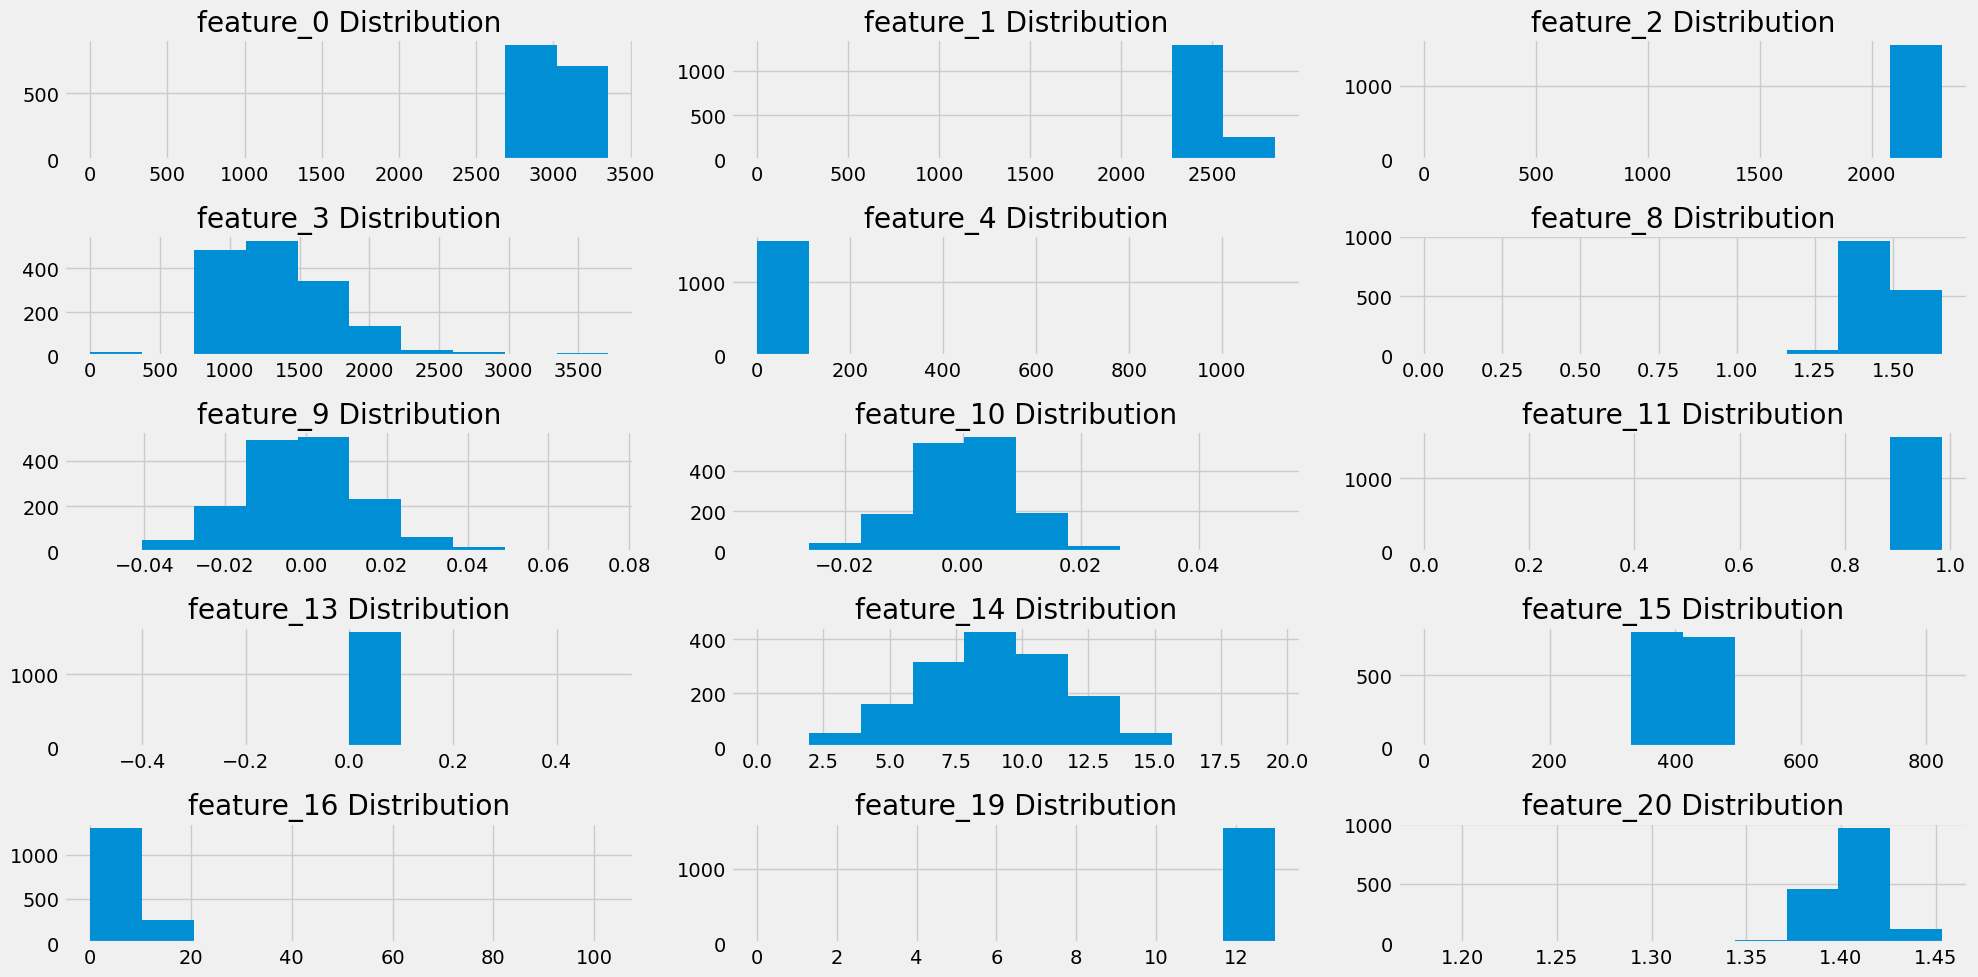

In [26]:
#Observation is that most of the variables distribution are right skewed with long tails and outliers 
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(20,10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

#Most the variables are approximately normally distributed except for feature_4, feature_7,
#feature_11, feature_12, feature_15, feature_16
draw_histograms(data, data.iloc[:,0:15], 5, 3)

In [27]:
# separating the dependent and independent data

x = data.iloc[:,:306]
y = data["Pass_Fail"]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


In [28]:
# splitting them into train test and split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

# gettiing the shapes
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1096, 306)
shape of x_test:  (471, 306)
shape of y_train:  (1096,)
shape of y_test:  (471,)


In [29]:
# standardization

from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [30]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, Y_train = oversample.fit_resample(x_train, y_train)

In [31]:
# Hyperparameter tuning takes a lot of time. If this variable is False, the tuning process will be omitted and the learning will proceed 
# with the hyperparameters already obtained. If this variable is true, you can proceed with the tuning process directly.
allow_tuning = True

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

if allow_tuning:
    params_knn = {
        'n_neighbors': range(1, 10),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
        'p': [1, 2]
    }
    model_knn = KNeighborsClassifier()
    search_knn = GridSearchCV(model_knn, params_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, Y_train)
    print(search_knn.best_params_)

    params_logistic = {
        'max_iter': [2000],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 20),
        'solver': ['liblinear']
    }
    model_logistic = LogisticRegression()
    search_logistic = GridSearchCV(model_logistic, params_logistic, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, Y_train)
    print(search_logistic.best_params_)

    params_svc = {'kernel': ['rbf'], 'gamma': [i/10000 for i in range(90, 110)], 'C': range(50, 80, 10), 'probability': [True]}
    model_svc = SVC()
    search_svc = GridSearchCV(model_svc, params_svc, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, Y_train)
    print(search_svc.best_params_)

    params_rf = {
        'n_estimators': [95, 100, 105],
        'criterion': ['entropy'],
        'bootstrap': [True, False],
        'max_depth': [40, 45, 50],
        'max_features': [4, 5, 6],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [9, 10, 11],
        'random_state': [242]  # Set random_state here
    }
    model_rf = RandomForestClassifier(random_state=242)  # Initialize the model with random_state
    search_rf = GridSearchCV(model_rf, params_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1).fit(X_train, Y_train)
    print(search_rf.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'algorithm': 'auto', 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 78.47599703514607, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 50, 'gamma': 0.0095, 'kernel': 'rbf', 'probability': True}
Fitting 5 folds for each of 486 candidates, totalling 2430 fits
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 40, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 95, 'random_state': 242}


In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

if allow_tuning:
    model_knn = search_knn.best_estimator_
    model_logistic = search_logistic.best_estimator_
    model_svc = search_svc.best_estimator_
    model_rf = search_rf.best_estimator_
    xgb_params = {
        'base_score': 0.5, 
        'booster': 'gbtree', 
        'colsample_bylevel': 1,
        'colsample_bynode': 1, 
        'colsample_bytree': 0.8,
        'enable_categorical': False, 
        'eval_metric': 'logloss', 
        'gamma': 0.8,
        'gpu_id': -1, 
        'importance_type': None, 
        'interaction_constraints': '',
        'learning_rate': 0.15, 
        'max_delta_step': 0, 
        'max_depth': 5,
        'min_child_weight': 1, 
        'missing': np.nan, 
        'monotone_constraints': '()',
        'n_estimators': 15, 
        'n_jobs': -1, 
        'num_parallel_tree': 1, 
        'predictor': 'auto',
        'random_state': 0, 
        'reg_alpha': 1e-05, 
        'reg_lambda': 1, 
        'scale_pos_weight': 1,
        'subsample': 0.8, 
        'tree_method': 'exact', 
        'use_label_encoder': False,
        'validate_parameters': 1, 
        'verbosity': 0
    }
else:
    model_knn = KNeighborsClassifier(algorithm='auto', n_neighbors=9, p=1, weights='uniform')
    model_logistic = LogisticRegression(C=0.08858667904100823, max_iter=2000, penalty='l2', solver='liblinear')
    model_svc = SVC(C=70, gamma=0.0106, kernel='rbf', probability=True)
    model_rf = RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth=50, max_features=6, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=734)
    xgb_params = {
        'base_score': 0.5, 
        'booster': 'gbtree', 
        'colsample_bylevel': 1,
        'colsample_bynode': 1, 
        'colsample_bytree': 0.8,
        'enable_categorical': False, 
        'eval_metric': 'logloss', 
        'gamma': 0.8,
        'gpu_id': -1, 
        'importance_type': None, 
        'interaction_constraints': '',
        'learning_rate': 0.15, 
        'max_delta_step': 0, 
        'max_depth': 5,
        'min_child_weight': 1, 
        'missing': np.nan, 
        'monotone_constraints': '()',
        'n_estimators': 15, 
        'n_jobs': -1, 
        'num_parallel_tree': 1, 
        'predictor': 'auto',
        'random_state': 0, 
        'reg_alpha': 1e-05, 
        'reg_lambda': 1, 
        'scale_pos_weight': 1,
        'subsample': 0.8, 
        'tree_method': 'exact', 
        'use_label_encoder': False,
        'validate_parameters': 1, 
        'verbosity': 0
    }

models = {
    'knn': model_knn,
    'logistic': model_logistic,
    'svc': model_svc,
    'rf': model_rf,
    'xgb': XGBClassifier(**xgb_params)
}


In [51]:
import copy

# goal: The number of models to combine.
# estimaors: empty list.
# voting: voting method.
def select_models(start, cnt, goal, estimators, voting):
    if cnt == goal:
        estimators_copy = copy.deepcopy(estimators)
        voting_name = f'{voting}_' + '_'.join([i[0] for i in list(estimators_copy)])
        models[voting_name] = VotingClassifier(estimators=estimators_copy, voting=voting)
        return
    for i in range(start, 5):
        estimators.append(list(models.items())[i])
        select_models(i + 1, cnt + 1, goal, estimators, voting)
        estimators.pop()

In [55]:
# create voting models
select_models(0, 0, 2, [], 'hard')
select_models(0, 0, 3, [], 'hard')
select_models(0, 0, 4, [], 'hard')
select_models(0, 0, 5, [], 'hard')

select_models(0, 0, 2, [], 'soft')
select_models(0, 0, 3, [], 'soft')
select_models(0, 0, 4, [], 'soft')
select_models(0, 0, 5, [], 'soft')

In [56]:
# Dictionary for storing results for each model.
result_by_model = pd.DataFrame({'model name': models.keys(), 'model': models.values(), 'score': 0})

In [59]:
# Assuming your current Y_train has classes [-1, 1]
# You can map -1 to 0 and keep 1 as it is to get [0, 1] classes
Y_train = (Y_train + 1) // 2
# Modify the target variable to have classes [0, 1]
Y_train = (Y_train + 1) // 2

# Cross-validation progresses for all models.
for name, model in models.items():
    result_by_model.loc[result_by_model['model name'] == name, 'score'] = cross_val_score(model, X_train, Y_train, cv=5).mean()

# The rest of your code
import pandas as pd

# Create an empty DataFrame with the required columns
result_by_model = pd.DataFrame(columns=['model name', 'score'])

# Initialize the 'score' column with NaN
result_by_model['score'] = float('nan')


In [60]:
# Cross validation scores of all models.
result_by_model.sort_values('score', ascending=False).reset_index(drop=True)

,model name,score


In [63]:
from xgboost import XGBClassifier  # Import XGBoost classifier

# Assuming you have a Soft KNN model (soft_knn_model) and a Random Forest model (rf_model) already defined
# Initialize XGBoost classifier
xgb_model = XGBClassifier()

# Create a dictionary to store the models
models = {
    'soft_knn_rf_xgb': xgb_model,  # Add XGBoost to the dictionary
    'soft_knn': soft_knn_model,     # Add Soft KNN to the dictionary
    'random_forest': rf_model       # Add Random Forest to the dictionary
}

# Rest of your code
model_name = 'soft_knn_rf_xgb'

try:
    models[model_name].fit(X_train, Y_train)
    y_pred = models[model_name].predict(X_test).astype(int)
except Exception as e:
    print(f"An error occurred: {str(e}")

# Now you can use 'y_pred' for further analysis or evaluation.


SyntaxError: f-string: closing parenthesis '}' does not match opening parenthesis '(' (3882881810.py, line 21)